In [1]:
!pip install -q transformers
!pip install -q datasets==2.7.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
pathos 0.3.2 requires dill>=0.3.8, but you have dill 0.3.6 which is incompatible.
pathos 0.3.2 requires multiprocess>=0.70.16, but you have multiprocess 0.70.14 which is incompatible.


In [2]:
import base64
import cv2
import json
import os
import requests
import torch

import numpy as np
import pandas as pd

from datasets import Features, Sequence, Value, Dataset
from datasets import Image as Img
from PIL import Image, ImageDraw, ImageFont
from transformers import (
    AutoTokenizer,
    LiltForTokenClassification
)
from torch.utils.data import DataLoader

# Получение секретов Yandex Cloud


In [3]:
with open('/kaggle/input/piad-data-full/yc_secrets.json') as f:
    yc_secrets = json.load(f)

# Получение iam токена
iam_url = 'https://iam.api.cloud.yandex.net/iam/v1/tokens'
data = {
    'yandexPassportOauthToken': yc_secrets['oauth_token']
}
iam_token = requests.post(iam_url, json=data).json()['iamToken']
folder_id = yc_secrets['folder_id']
url = 'https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText'

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {iam_token}',
    'x-folder-id': folder_id,
    'x-data-logging-enabled': 'true'
}

# Подготовка датасета для инференса  
* Чтение и кодировние изображений из заданной директории
* Получение ответа от Yandex Vision OCR
* Сбор датасета

In [4]:
# Yandex Vision OCR требует файлы в кодировке base64
def get_encoded_file(file_path):
    with open(file_path,'rb') as f:
        file_content = f.read()
    return base64.b64encode(file_content).decode('utf-8')


def get_mime_type(file_path):
    if file_path.endswith('.jpg') or file_path.endswith('.jpeg'):
        mime_type = 'JPEG'
    elif file_path.endswith('.png'):
        mime_type = 'PNG'
    elif file_path.endswith('.gif'):
        mime_type = 'GIF'
    elif file_path.endswith('.pdf'):
        mime_type = 'application/pdf'
    return mime_type


def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]


root_path = '/kaggle/input/piad-data-full/samples'
file_paths = os.listdir(root_path)
file_paths = [f for f in file_paths if f.endswith(('.png', '.jpeg', '.jpg', '.pdf', '.gif'))]

words, bboxes, images, paths = [], [], [], []
for file_path in file_paths:
    mime_type = get_mime_type(file_path)
    encoded_file = get_encoded_file(f'{root_path}/{file_path}')
    body_json = {
        'mimeType': mime_type,
        'languageCodes': ['ru','en'],
        'model': 'page',
        'content': encoded_file
    }
    
    response = requests.post(url, headers=headers, data=json.dumps(body_json))
    
    width = int(response.json()['result']['textAnnotation']['width'])
    height = int(response.json()['result']['textAnnotation']['height'])
    
    words.append(
        [
            word['text'] 
            for block in response.json()['result']['textAnnotation']['blocks'] 
            for line in block['lines'] 
            for word in line['words']
        ]
    )
    bboxes.append(
        [
            normalize_bbox(
                [
                    int(word['boundingBox']['vertices'][0]['x']), 
                    int(word['boundingBox']['vertices'][0]['y']),
                    int(word['boundingBox']['vertices'][2]['x']), 
                    int(word['boundingBox']['vertices'][2]['y'])
                ],
                width, height
            )
            for block in response.json()['result']['textAnnotation']['blocks'] 
            for line in block['lines'] 
            for word in line['words']
        ]
    )
    images.append(Image.open(f'{root_path}/{file_path}').convert('RGB'))
    paths.append(f'{root_path}/{file_path}')
    
dataset_dict = {
    'id': range(len(words)),
    'words': words,
    'bboxes': bboxes,
    'image': images,
    'path': paths
}
features = Features({
    'id': Value(dtype='string', id=None),
    'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
    'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
    'image': Img(decode=True, id=None),
    'path': Value(dtype='string', id=None),
})
dataset = Dataset.from_dict(dataset_dict, features=features)

## PyTorch Dataset  
Создание кастомного датасета для модели LiLT, применение предобученного токенизатора

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = example['image']
        words = example['words']
        boxes = example['bboxes']

        width, height = image.size

        bbox = []
        for word, box in zip(words, boxes):
            n_word_tokens = len(tokenizer.tokenize(word))
            bbox.extend([box] * n_word_tokens)

        cls_box = sep_box = [0, 0, 0, 0]
        bbox = [cls_box] + bbox + [sep_box]

        encoding = self.tokenizer(' '.join(words), truncation=True, max_length=512)
        sequence_length = len(encoding.input_ids)
        
        bbox = bbox[:sequence_length]
        encoding['bbox'] = bbox

        return encoding
    
tokenizer = AutoTokenizer.from_pretrained('nielsr/lilt-xlm-roberta-base')
lilt_dataset = CustomDataset(dataset, tokenizer)

tokenizer_config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

# PyTorch DataLoader
Создание DataLoader для инференса

In [6]:
def collate_fn(features):
    boxes = [feature['bbox'] for feature in features]

    batch = tokenizer.pad(features, padding='max_length', max_length=512)
    sequence_length = torch.tensor(batch['input_ids']).shape[1]
    batch['bbox'] = [boxes_example + [[0, 0, 0, 0]] * (sequence_length - len(boxes_example)) for boxes_example in boxes]
    batch = {k: torch.tensor(v) for k, v in batch.items()}

    return batch

dataloader = DataLoader(lilt_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Инференс

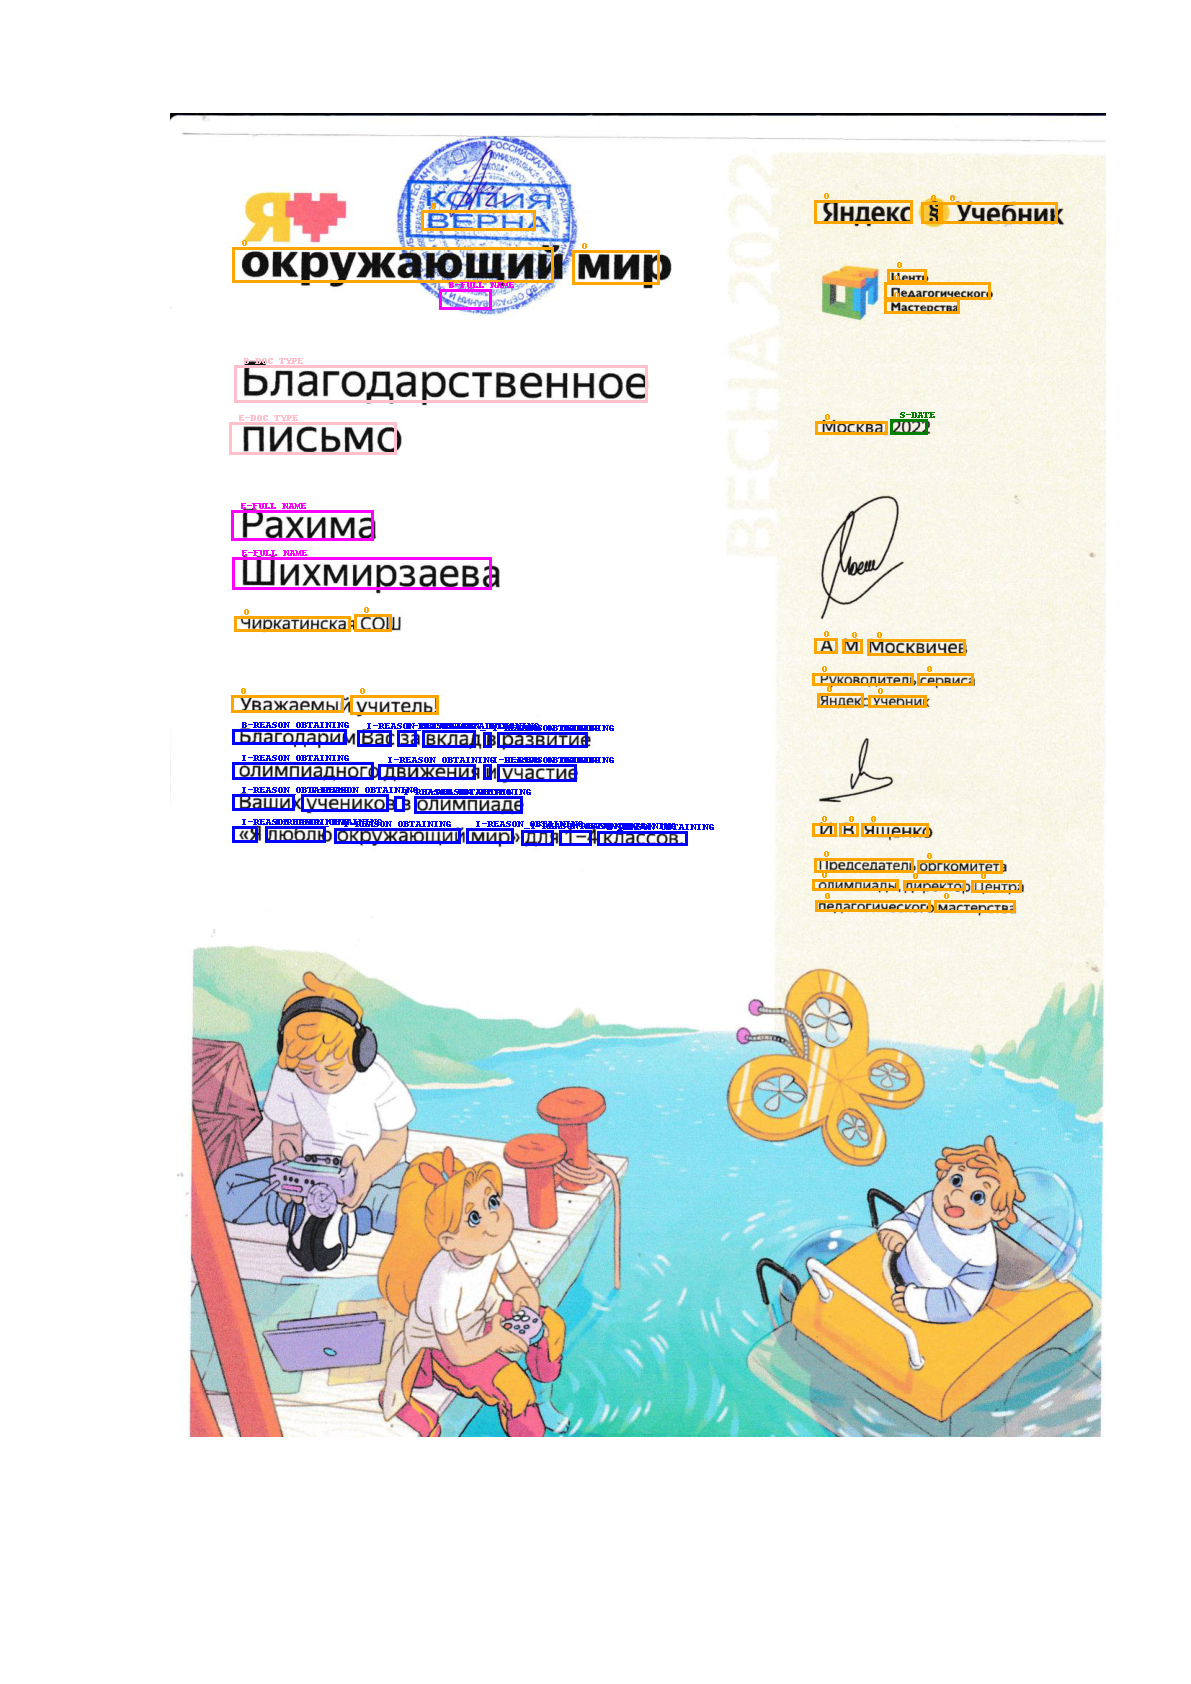

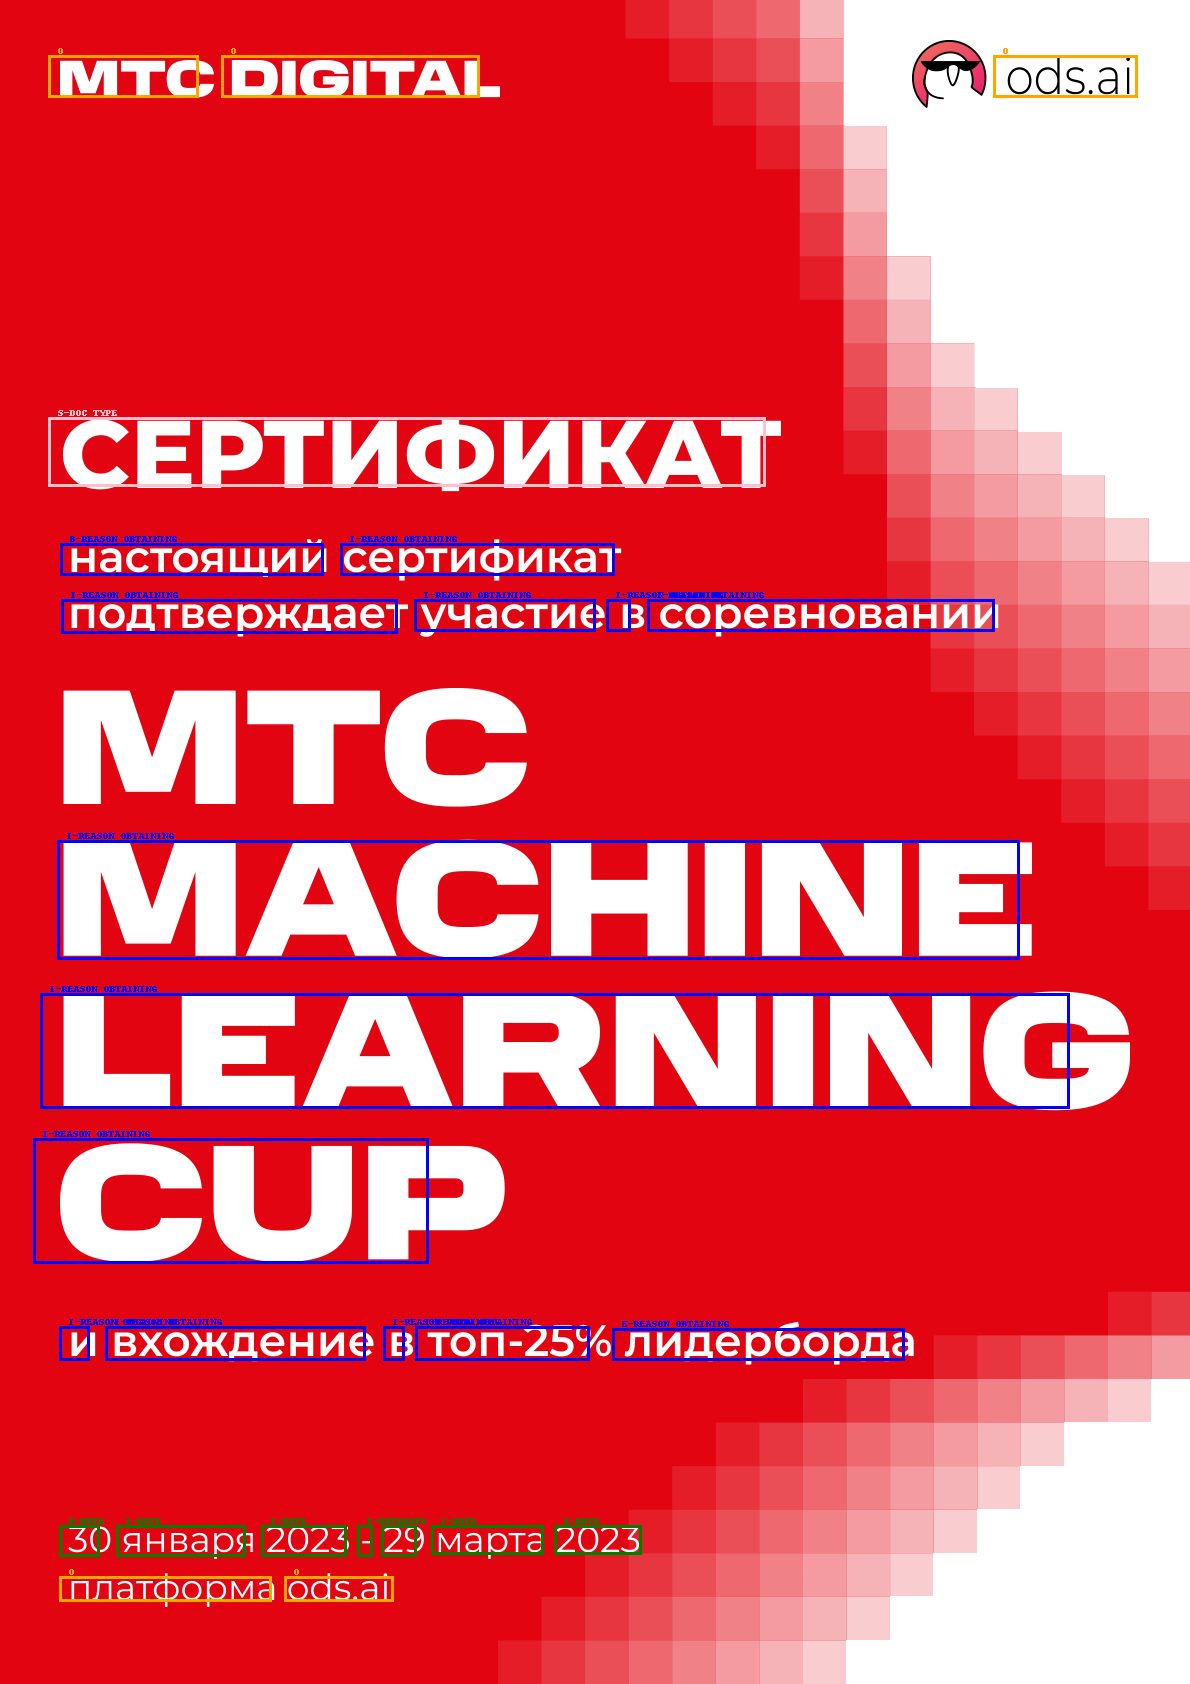

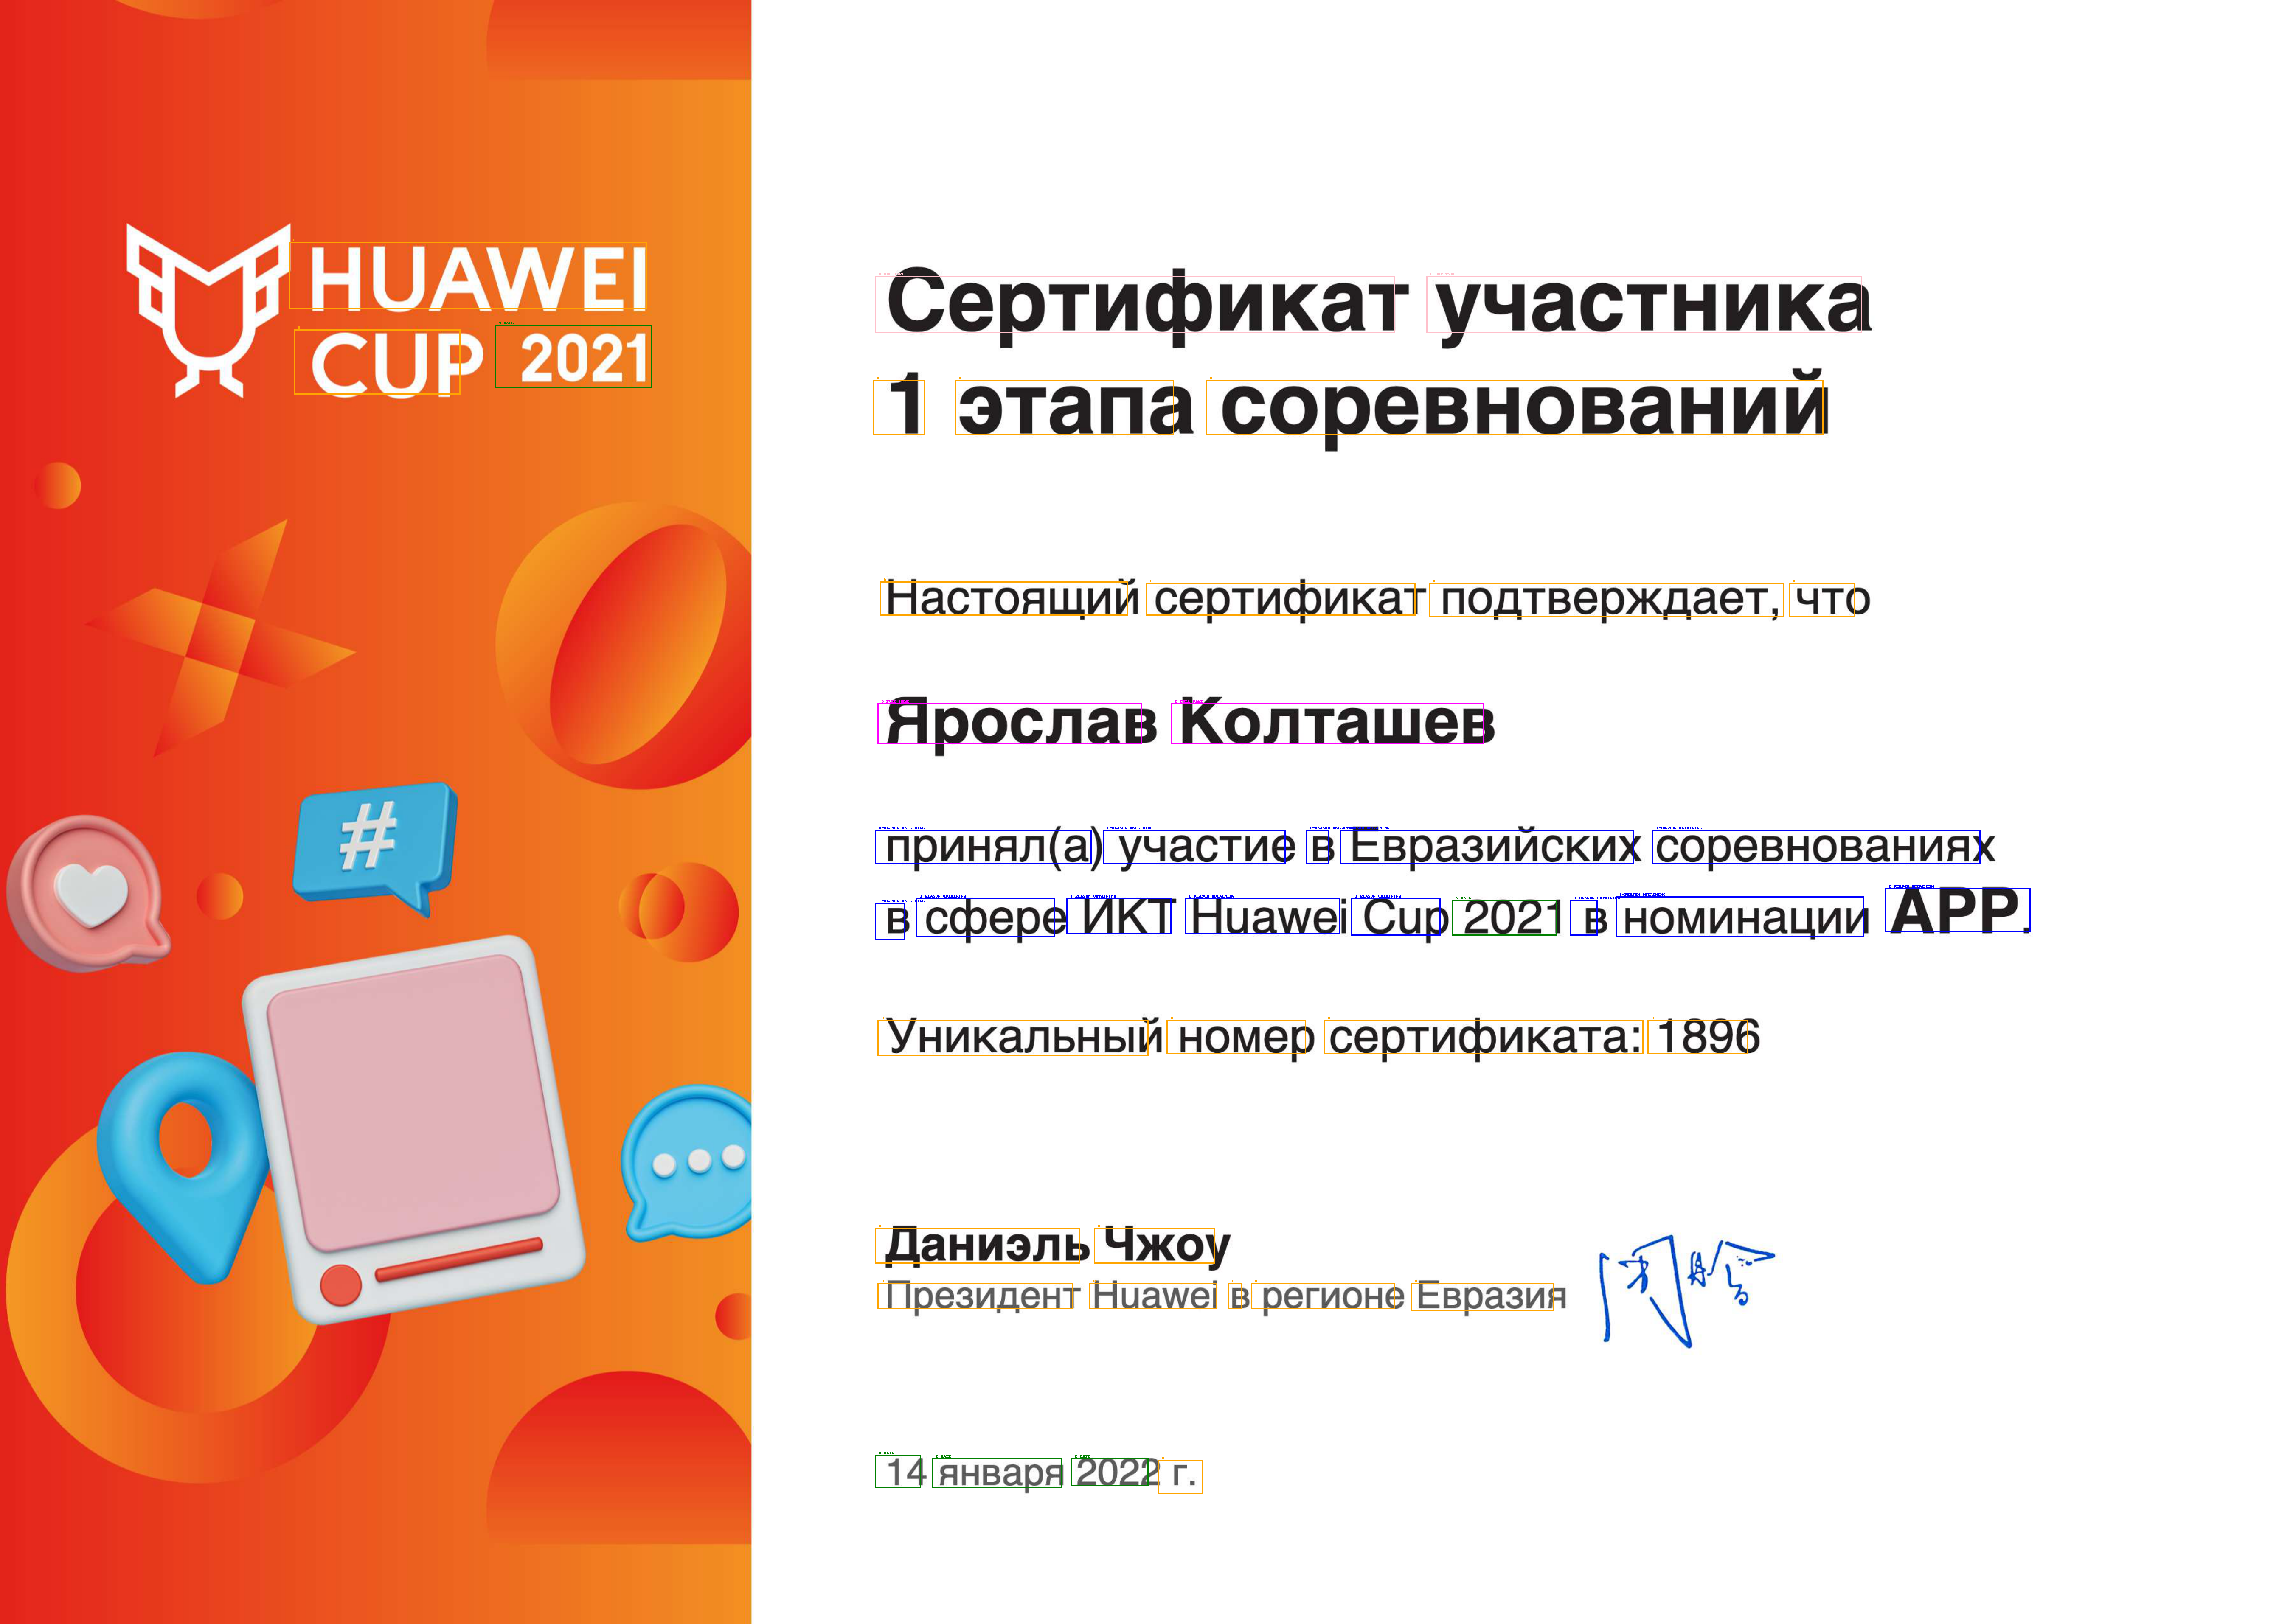

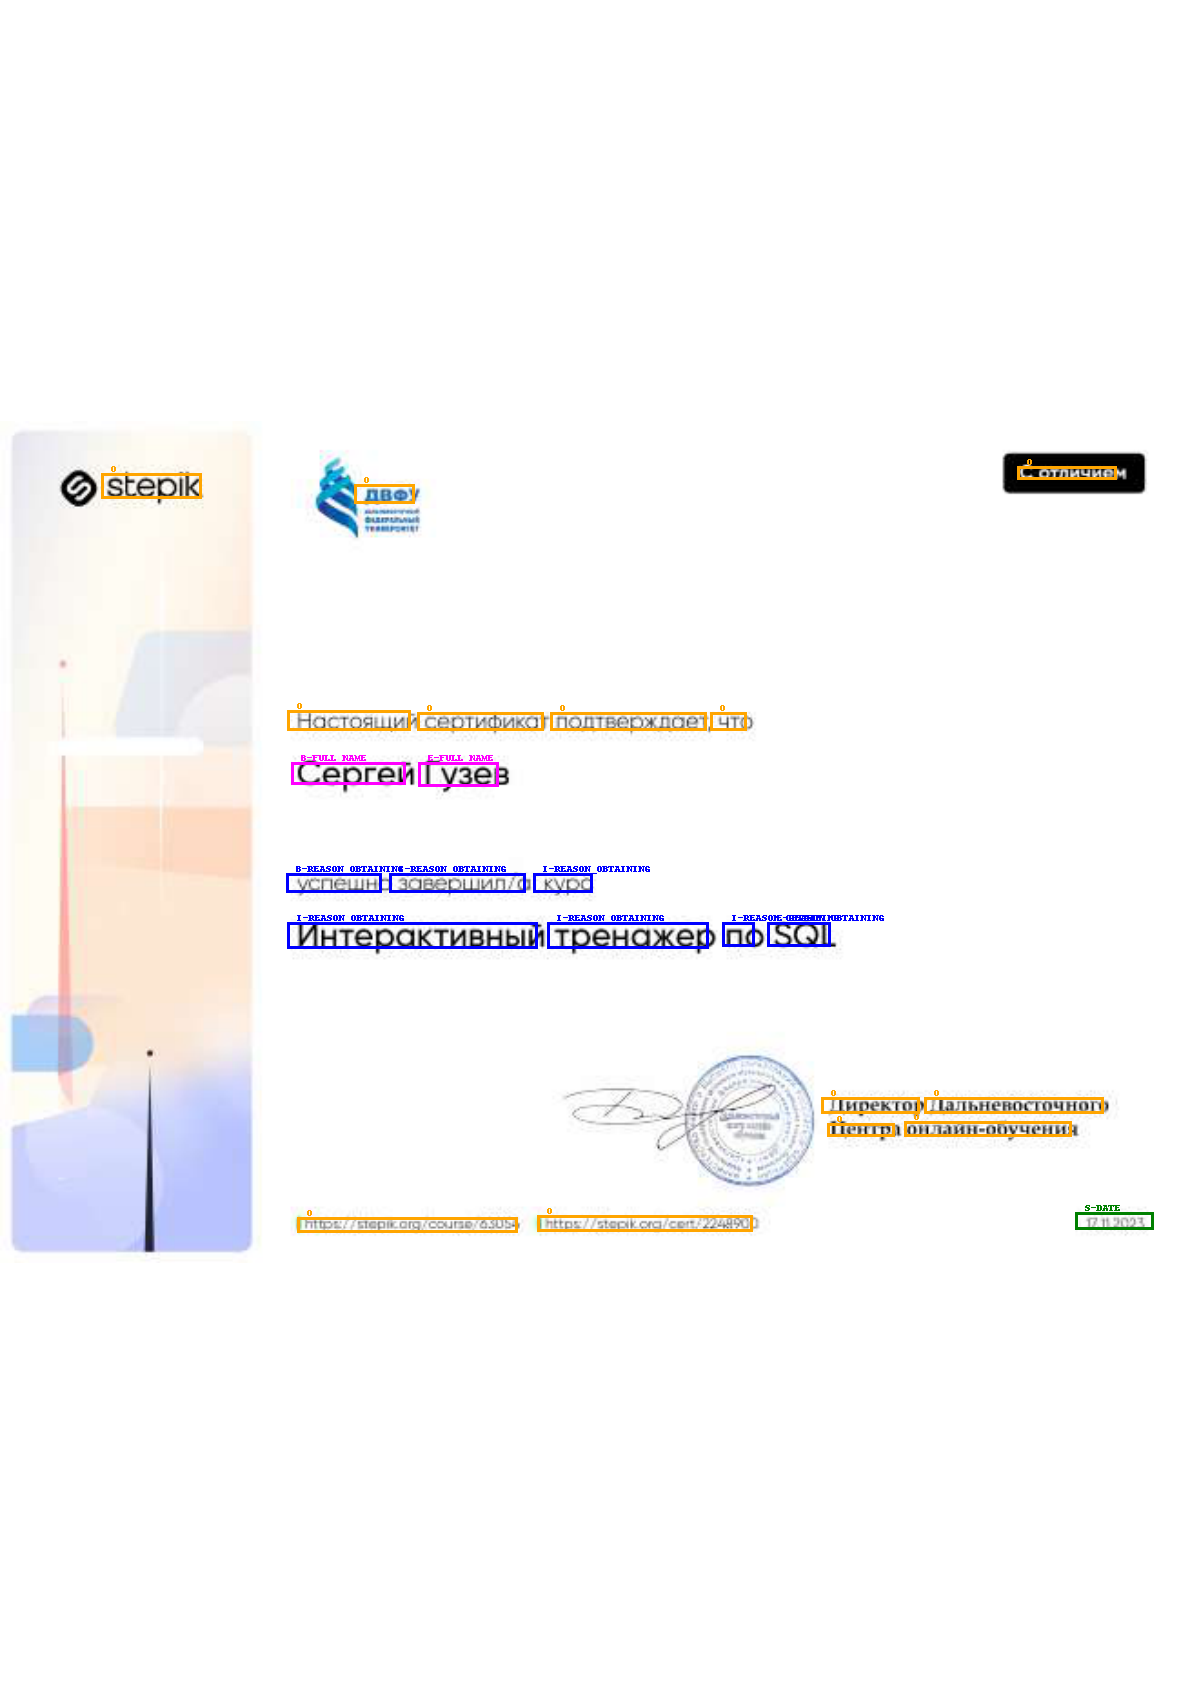

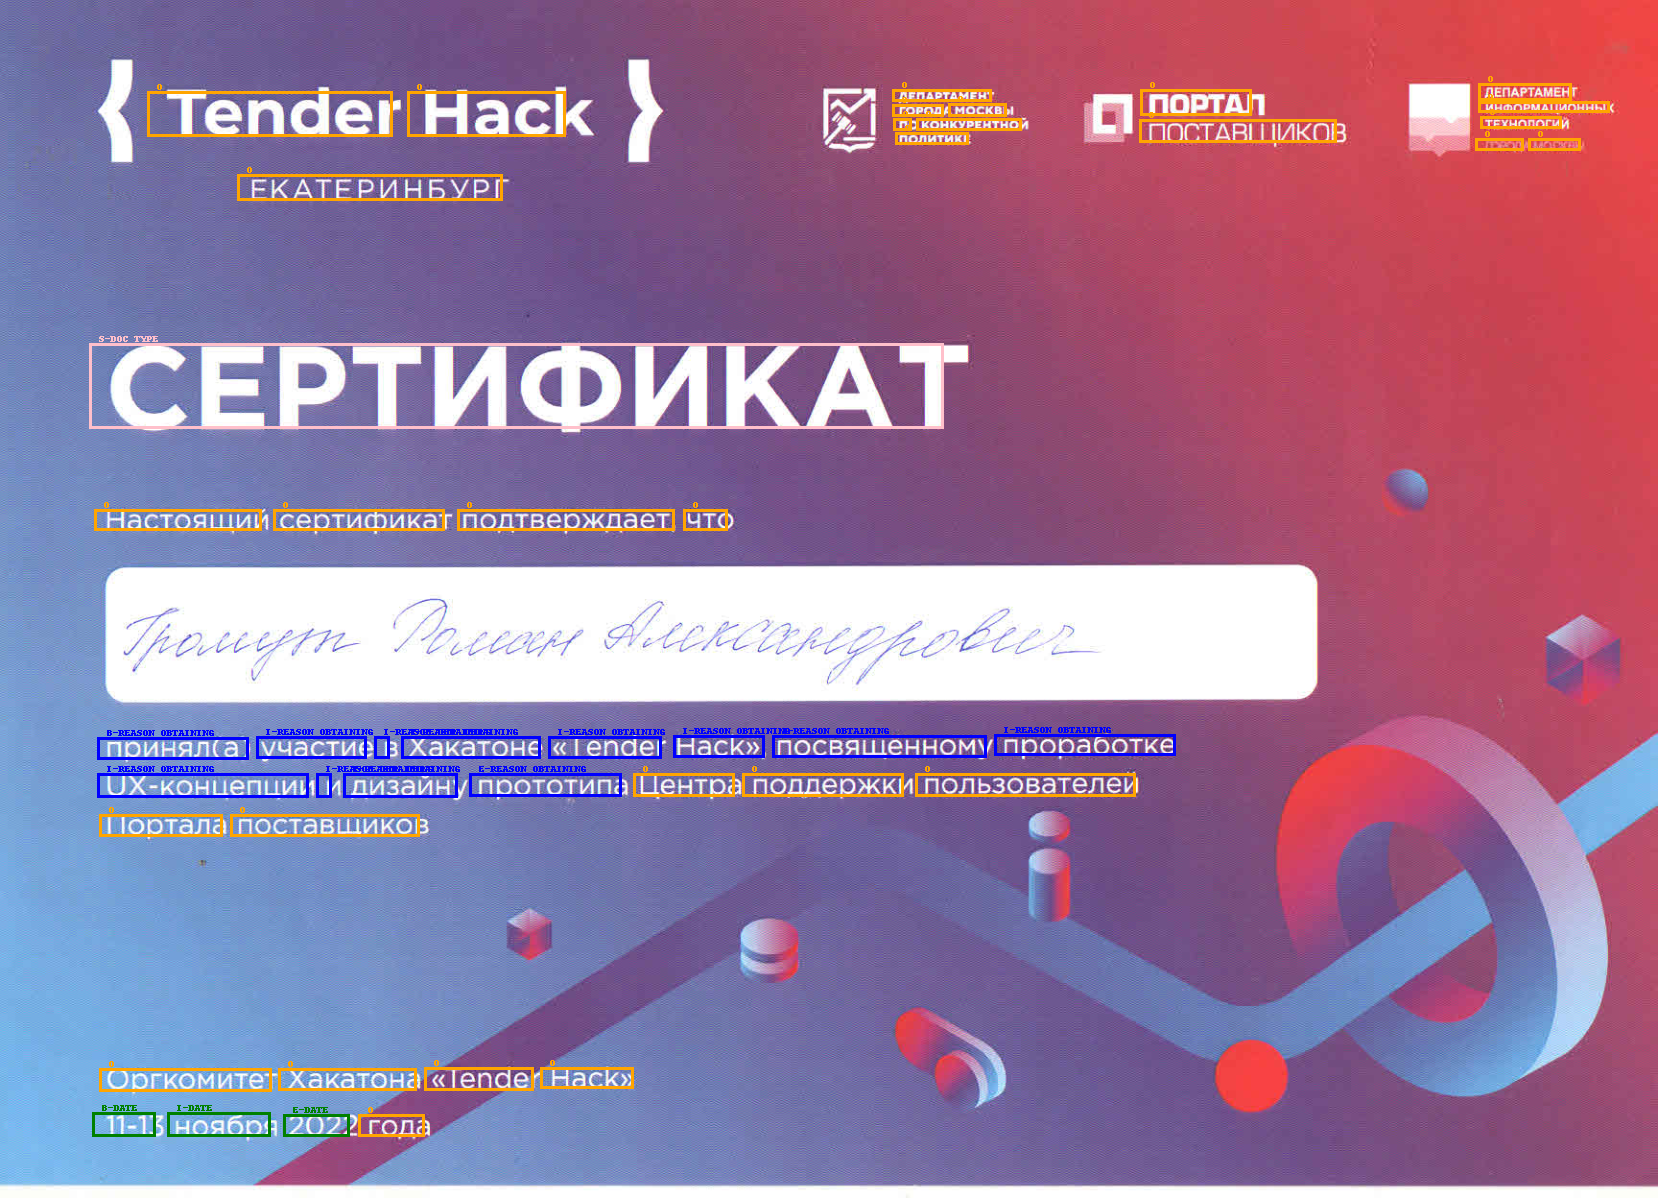

In [8]:
label2color = {
    'B-DATE': 'green',
    'B-DOC_TYPE': 'pink',
    'B-PLACE': 'yellow',
    'B-FULL_NAME': 'magenta',
    'B-REASON_OBTAINING': 'blue',
    'E-DATE': 'green',
    'E-DOC_TYPE': 'pink',
    'E-PLACE': 'yellow',
    'E-FULL_NAME': 'magenta',
    'E-REASON_OBTAINING': 'blue',
    'I-DATE': 'green',
    'I-DOC_TYPE': 'pink',
    'I-PLACE': 'yellow',
    'I-FULL_NAME': 'magenta',
    'I-REASON_OBTAINING': 'blue',
    'S-DATE': 'green',
    'S-DOC_TYPE': 'pink',
    'S-PLACE': 'yellow',
    'S-FULL_NAME': 'magenta',
    'S-REASON_OBTAINING': 'blue',
    'O': 'orange',
}

def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    draw = ImageDraw.Draw(image)
#     font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
#     font = ImageFont.truetype(font_path, size=24)

    for prediction, box in zip(predictions, normalizes_boxes):
        draw.rectangle(box, outline=label2color[prediction], width=3)
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction]) # font=font
    return image


def word_indices(bbox_list):
    '''
    Функция для очистки индексов от предсказаний по лишним токенам.
    Модель предоставляет предсказаня для токенов на уровне символов, 
    а требуются предсказания на уровне слов.
    '''
    occurrences = []
    indices = []
    for i, bbox in enumerate(bbox_list):
        if bbox not in occurrences and bbox != [0, 0, 0, 0]:
            occurrences.append(bbox)
            indices.append(i)
            
    return indices


def run_inference(dataloader, model):
    predictions = []
    
    for batch in dataloader:

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        bboxes = batch['bbox']
        
        outputs = model(input_ids=input_ids, bbox=bboxes, attention_mask=attention_mask)
        token_predictions = outputs.logits.argmax(-1).squeeze().tolist()
        
        indices = word_indices(bboxes.squeeze().tolist())
        word_predictions = [token_predictions[i] for i in indices]
        predictions.append(word_predictions)
        
    return predictions

model = LiltForTokenClassification.from_pretrained('koshkidadanet/lilt-xlm-roberta-base-finetuned-piad')
predictions = run_inference(dataloader, model=model)

labels = [[model.config.id2label[p] for p in pred] for pred in predictions]

for i in range(5):
    display(draw_boxes(dataset[i]['image'], dataset[i]['bboxes'], labels[i]))

# Формируем итоговую таблицу

In [9]:
def get_ner_elements(raw_elements):
    str_el = ''
    ner_elements= []
    
    for pair in raw_elements:    
        if pair[1].startswith('S') or pair[1].startswith('E'):
            str_el += pair[0]
            ner_elements.append(str_el)
            str_el = ''
        else:
            str_el += f'{pair[0]} '
            
    return ner_elements


paths = []
date, name, doc_type, place = [], [], [], []

for el, tegs in zip(dataset, labels):
    raw_date, raw_name, raw_doc_type, raw_place = [], [], [], []
    
    for word, w_teg in zip(el['words'], tegs):
        if 'DATE' in w_teg:
            raw_date.append((word, w_teg))
        elif 'FULL_NAME' in w_teg:
            raw_name.append((word, w_teg))
        elif 'DOC_TYPE' in w_teg:
            raw_doc_type.append((word, w_teg))
        elif 'PLASE' in w_teg:
            raw_place.append((word, w_teg))
            
    date.append(get_ner_elements(raw_date))
    name.append(get_ner_elements(raw_name))
    doc_type.append(max(get_ner_elements(raw_doc_type), key=len, default=None))
    place.append(max(get_ner_elements(raw_place), key=len, default=None))
    paths.append(el['path'])
    
pd.DataFrame(
    {
        'path': paths,
        'date': date,
        'name': name,
        'doc_type': doc_type,
        'place': place
    }
)

path  \
0  /kaggle/input/piad-data-full/samples/ilovepdf_...   
1  /kaggle/input/piad-data-full/samples/MTS 25_im...   
2  /kaggle/input/piad-data-full/samples/098f598b3...   
3  /kaggle/input/piad-data-full/samples/72b562eba...   
4  /kaggle/input/piad-data-full/samples/����䨪�� T...   
5  /kaggle/input/piad-data-full/samples/1_�⠯_��㤥�...   
6  /kaggle/input/piad-data-full/samples/ilovepdf_...   
7  /kaggle/input/piad-data-full/samples/�ࠬ�� ��� ...   
8  /kaggle/input/piad-data-full/samples/����㭠த�� ...   
9  /kaggle/input/piad-data-full/samples/ilovepdf_...   

                               date                              name  \
0                            [2022]      [Рахима, Ининуа Шихмирзаева]   
1  [30 января 2023 - 29 марта 2023]                                []   
2      [2021, 2021, 14 января 2022]                [Ярослав Колташев]   
3                     [17.11.2023.]                    [Сергей Гузев]   
4               [11-13 ноября 2022]                                []   
5  [2020/21», 2020/21», 28.06.2021]                [Ярослав Колташев]   
6           [10 февраля 2022, 2022]  [Шихмирзаева Рахима Ибрагимовна]   
7         [22.11.2021 - 26.11.2021]      [Громут Роман Александрович]   
8  [(2023, 23.11.2023 - 26.11.2023]                 [Резников Кирилл]   
9                            [2010]     [Митькиной Татьяне Сергеевме]   

                  doc_type place  
0  Благодарственное письмо  None  
1               СЕРТИФИКАТ  None  
2     Сертификат участника  None  
3                     None  None  
4               СЕРТИФИКАТ  None  
5     Сертификат участника  None  
6               СЕРТИФИКАТ  None  
7                  ГРАМОТА  None  
8     СЕРТИФИКАТ УЧАСТНИКА  None  
9                  ДИПЛОМ)  None